In [12]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax.random as jrandom
import optax
import numpy as np
import matplotlib.pyplot as plt

from sampling_utils import get_samples, get_z_samples
from reparameterization import get_rp_gradients, objective
from likelihoodratio import get_lr_gradients
from constants import RAND_KEY
from training import fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Initial Parameters

In [5]:
mu_0 = 1.
V_0 = 0.0001

A = 1.
B = 1.

C = 1.
E = 1.

In [6]:
zs, xs = get_samples(2, 1000, mu_0, V_0, A, B, C, E)

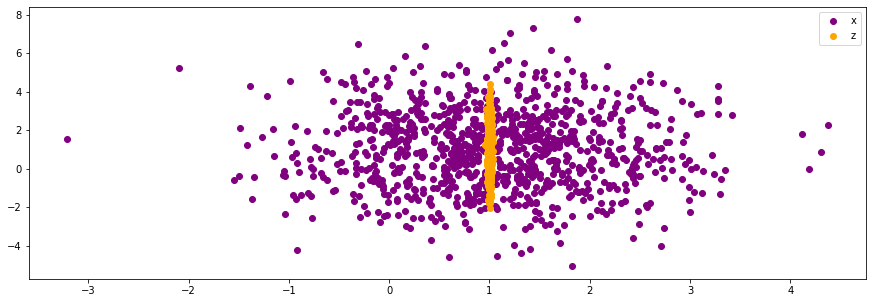

In [7]:
plt.figure(figsize=(15,5))
plt.scatter(xs[:-1], xs[1:], color="purple", label="x")
plt.scatter(zs[:-1], zs[1:], color="orange", label="z")
plt.legend()
plt.show()

## Find optimal A using gradient estimators

We try to maximise the marginal likelihood $\max_{A} \mathbb{E}_{p(Z|A, B, \mu_0, V_0)} [p(X|Z, C, E)]$ w.r.t $A$, by using LR and RP gradient estimators together with an Adam optimiser until convergence.

We assume here all other parameters ($\mu_0, V_0, B, C, E$) are known.

In [10]:
N = 1000000
num_inputs = 2
NUM_TRAIN_STEPS = 3000
A = 1.5

# Set to False for RP gradient estimator
LR_ESTIMATOR = True 

A_n = 1.
_, xs = get_samples(num_inputs, N, mu_0, V_0, A, B, C, E)

init_param = jnp.array([A_n])


optimizer = optax.chain(
    optax.adam(learning_rate=0.0005),
    optax.scale(-1.0)
)

optimizer.init(init_param)

learned_params, losses, gradients = fit(
    params=init_param,
    optimizer=optimizer, 
    training_steps=NUM_TRAIN_STEPS, 
    mu0=mu_0, V0=V_0, B=B, C=C, E=E, xs=xs, 
    num_inputs=num_inputs, 
    N=N, 
    lr_estimator=LR_ESTIMATOR,
)

Step 0, marginal likelihood: 0.044725, grad: 0.003749, A - 1.000500
Step 100, marginal likelihood: 0.044929, grad: 0.003399, A - 1.049713
Step 200, marginal likelihood: 0.045043, grad: 0.003076, A - 1.096287
Step 300, marginal likelihood: 0.045216, grad: 0.002704, A - 1.140560
Step 400, marginal likelihood: 0.045251, grad: 0.002428, A - 1.182139
Step 500, marginal likelihood: 0.045363, grad: 0.002056, A - 1.220870
Step 600, marginal likelihood: 0.045408, grad: 0.001826, A - 1.256842
Step 700, marginal likelihood: 0.045515, grad: 0.001598, A - 1.290119
Step 800, marginal likelihood: 0.045545, grad: 0.001291, A - 1.320534
Step 900, marginal likelihood: 0.045559, grad: 0.001196, A - 1.347811
Step 1000, marginal likelihood: 0.045554, grad: 0.001001, A - 1.372573
Step 1100, marginal likelihood: 0.045660, grad: 0.000800, A - 1.394711
Step 1200, marginal likelihood: 0.045631, grad: 0.000586, A - 1.414344
Step 1300, marginal likelihood: 0.045605, grad: 0.000542, A - 1.431037
Step 1400, margina

Max marginal likelihood reached by RP gradients: 0.0456
Max marginal likelihood reached by LR gradients: 0.0456
Marginal likelihood of true A: 0.0457


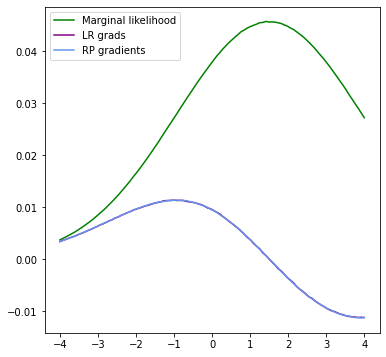

In [14]:
N = 1000000
As = np.linspace(-4, 4, 100)

_, xs = get_samples(num_inputs, N, mu_0, V_0, A, B, C, E)
lr_grads = np.zeros(100,)
rp_grads = np.zeros(100,)
obj = np.zeros(100,)
key = RAND_KEY
for i in range(100):
    a = As[i]
    key, subkey = jrandom.split(key)
    zs, epsilons = get_z_samples(num_inputs, N, mu_0, V_0, a, B, subkey)
    lr_grads[i] = get_lr_gradients(mu_0, V_0, a, B, C, E, xs, zs)
    rp_grads[i] = get_rp_gradients(mu_0, V_0, a, B, C, E, epsilons, xs)
    obj[i] = objective(mu_0, V_0, a, B, C, E, epsilons, xs)

print(f"Max marginal likelihood reached by RP gradients: {obj[np.argmin(list(map(lambda x: abs(x - 0), rp_grads)))]:.4f}")
print(f"Max marginal likelihood reached by LR gradients: {obj[np.argmin(list(map(lambda x: abs(x - 0), lr_grads)))]:.4f}")
print(f"Marginal likelihood of true A: {max(obj):.4f}")

plt.figure(figsize=(6,6))
plt.plot(As, obj, color="green", label="Marginal likelihood")
plt.plot(As, lr_grads, color="purple", label="LR grads")
plt.plot(As, rp_grads, color="cornflowerblue", label="RP gradients")
plt.legend()
plt.show()

#### LDS produced with learned parameter

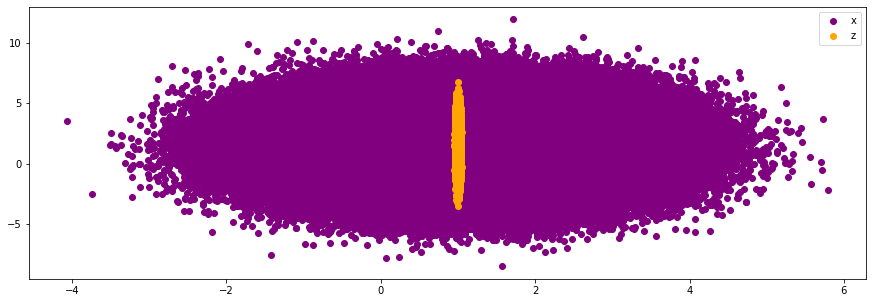

In [16]:
learned_A = learned_params[0]
zs, xs = get_samples(num_inputs, N, mu_0, V_0, learned_A, B, C, E)

plt.figure(figsize=(15,5))
plt.scatter(xs[:-1], xs[1:], color="purple", label="x")
plt.scatter(zs[:-1], zs[1:], color="orange", label="z")
plt.legend()
plt.show()